In [1]:

# Set up notebook
%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd


# DARPA ITM Medical Triage Paper

> Once we finalize all complete records for the registry (or identify the subset for analyses), based on our slack discussion, we'll need to redo some of the analyses for the paper. I made a listing below of what I think we need for the article and based on the feedback that I've received so far.

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df=''
)
triage_paper_df = data_frames_list['first_responder_master_registry_df']
file_stats_df = data_frames_list['first_responder_master_registry_file_stats_df']
scene_stats_df = data_frames_list['first_responder_master_registry_scene_stats_df']

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_file_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_scene_stats_df.pkl.


In [4]:

elevens_df = fu.get_elevens_data_frame(
    triage_paper_df, file_stats_df, scene_stats_df, needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category']
)


## Triage efficiency (mean, SD, median, IQR) by each responder type


* **Time to triage scene**

In [33]:

# Get info for Time to triage scene
from datetime import timedelta

cn = 'triage_time'
statistics_df = DataFrame([])
temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        df = Series(
            [fu.get_triage_time(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
        ).to_frame().rename(columns={0: cn})
        df = fu.get_statistics(df, [cn]).applymap(temporalize_fn, na_action='ignore')
        statistics_df = pd.concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
        ttts_dict = df.to_dict()[cn]
        print(
            f"{responder_category}: {ttts_dict['mean']} (SD = {ttts_dict['SD']}, Median = {ttts_dict['median']},"
            f" IQR = ({ttts_dict['25%']}, {ttts_dict['75%']}))"
        )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Triage Scene', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 8:19 (SD = 2:14, Median = 8:21, IQR = (7:31, 8:54))
EM-Faculty: 10:40 (SD = 4:12, Median = 9:53, IQR = (7:16, 13:18))
EMT-Basic: 8:17 (SD = 2:09, Median = 7:41, IQR = (6:47, 9:36))
Medical Student: 8:30 (SD = 2:28, Median = 8:44, IQR = (7:20, 10:09))
Paramedic: 7:34 (SD = 1:53, Median = 7:24, IQR = (6:13, 8:36))



,Mean Time to Triage Scene,SD,Median,IQR
EM Resident,8:19,2:14,8:21,"(7:31, 8:54)"
EM-Faculty,10:40,4:12,9:53,"(7:16, 13:18)"
EMT-Basic,8:17,2:09,7:41,"(6:47, 9:36)"
Medical Student,8:30,2:28,8:44,"(7:20, 10:09)"
Paramedic,7:34,1:53,7:24,"(6:13, 8:36)"


In [121]:

# Get whisker plot for Time to triage scene
import seaborn as sns
import matplotlib.pyplot as plt

def show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df):
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])
    responder_categories_list = ['EMT-Basic', 'Paramedic', 'Medical Student', 'EM Resident', 'EM-Faculty']
    responder_categories_dict = {o: n for o, n in zip(
        responder_categories_list, ['EMT-Basic', 'EMT-Paramedic', 'Medical Student', 'EM-Resident', 'EM-Faculty']
    )}
    rows_list = []
    for responder_category in responder_categories_list:
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        scene_count = gb.size().shape[0]
        for (session_uuid, scene_id), scene_df in gb:
            row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = scene_count
            rows_list.append(row_dict)
    df = DataFrame(rows_list)

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot of the y column grouped by the x column
    ax = sns.boxplot(
        x=x_column_name,
        y=y_column_name,
        showmeans=True,
        data=df,
        ax=ax
    )

    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(
            ytick_fn(ytick_value)
        )
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(responder_categories_dict[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

    plt.show()

In [ ]:

for responder_category, xlabel in zip(responder_categories_list, [text_obj.get_text() for text_obj in labels]):
    mask_series = (df[x_column_name] == responder_category)
    scene_count = df[mask_series].scene_count.tolist()[0]
    print(f'{xlabel}: {scene_count} responders')

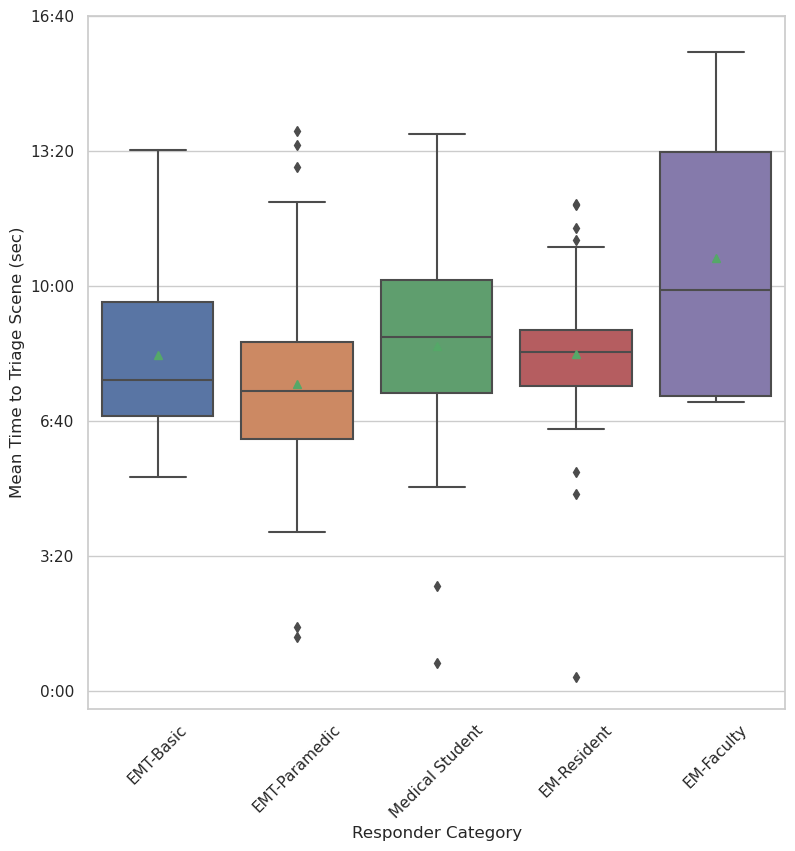

EMT-Basic: 23 responders
EMT-Paramedic: 225 responders
Medical Student: 46 responders
EM-Resident: 33 responders
EM-Faculty: 4 responders


In [99]:

y_column_name = 'triage_time'
y_label = 'Mean Time to Triage Scene (sec)'
scene_fn = lambda scene_df: fu.get_triage_time(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


* **Hemorrhage Control for all Life-threatening Bleeding (and percentage of participants who implemented all required hemorrhage control)**

In [88]:

# Get info for Hemorrhage control for all life-threatening bleeding percentage
cn = 'last_controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        df = Series(
            [fu.get_time_to_last_hemorrhage_controlled(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
        ).to_frame().rename(columns={0: cn})
        df = fu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore')
        hcfaltb_dict = df.to_dict()[cn]
        df = df.rename(columns={cn: responder_category}).T
        phc = int(Series(
            [fu.get_percent_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
        ).mean())
        df['phc'] = phc
        statistics_df = pd.concat([statistics_df, df], axis='index')
        print(
            f"{responder_category}: {hcfaltb_dict['mean']} at {phc}% (SD = {hcfaltb_dict['SD']}, Median = {hcfaltb_dict['median']},"
            f" IQR = ({hcfaltb_dict['25%']}, {hcfaltb_dict['75%']}))"
        )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time to Hemorrhage Control', '%', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[3], 'phc':  columns_list[1]})[columns_list].to_html())

EM Resident: 6:01 at 44% (SD = 2:06, Median = 5:40, IQR = (4:56, 7:24))
EM-Faculty: 8:12 at 51% (SD = 3:41, Median = 8:00, IQR = (5:24, 10:48))
EMT-Basic: 5:14 at 52% (SD = 2:12, Median = 4:25, IQR = (3:55, 6:21))
Medical Student: 5:44 at 43% (SD = 2:21, Median = 5:34, IQR = (4:35, 6:38))
Paramedic: 5:05 at 50% (SD = 1:39, Median = 4:53, IQR = (4:02, 5:57))



,Mean Time to Hemorrhage Control,%,SD,Median,IQR
EM Resident,6:01,44,2:06,5:40,"(4:56, 7:24)"
EM-Faculty,8:12,51,3:41,8:00,"(5:24, 10:48)"
EMT-Basic,5:14,52,2:12,4:25,"(3:55, 6:21)"
Medical Student,5:44,43,2:21,5:34,"(4:35, 6:38)"
Paramedic,5:05,50,1:39,4:53,"(4:02, 5:57)"


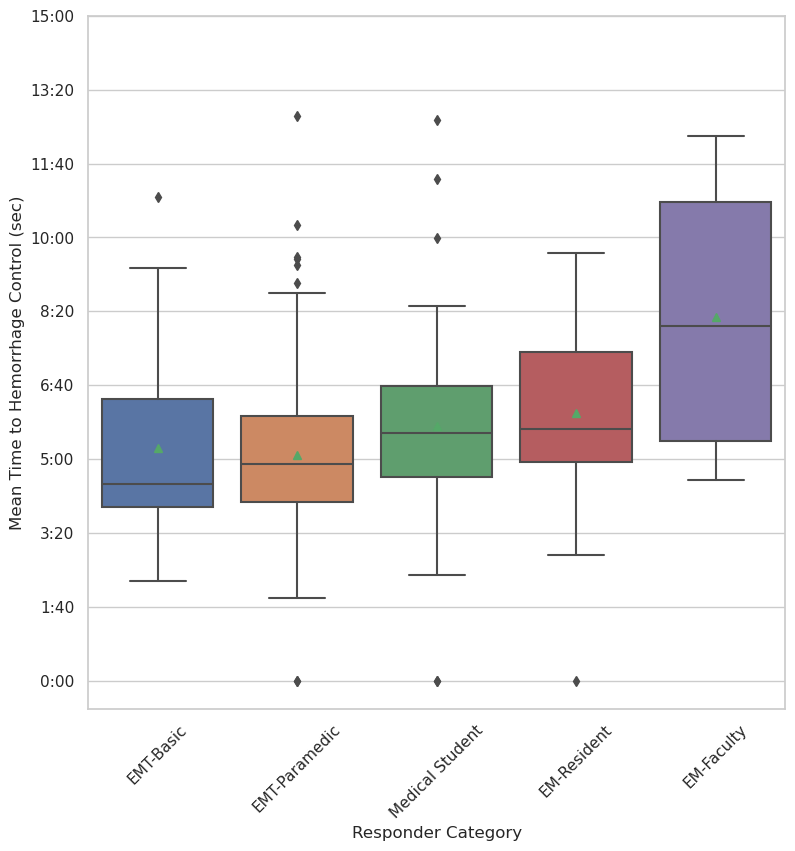

EMT-Basic: 23 responders
EMT-Paramedic: 225 responders
Medical Student: 46 responders
EM-Resident: 33 responders
EM-Faculty: 4 responders


In [100]:

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Mean Time to Hemorrhage Control (sec)'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


* **Hemorrhage Control per Patient**

In [92]:

# Get info for Hemorrhage control per patient
cn = 'controlled_time'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        times_list = []
        for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns):
            for _, patient_df in scene_df.groupby('patient_id'):
                if fu.is_patient_hemorrhaging(patient_df):
                    controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=None)
                    times_list.append(controlled_time)
        df = Series(times_list).to_frame().rename(columns={0: cn})
        df = fu.get_statistics(df, [cn]).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='seconds'), na_action='ignore')
        statistics_df = pd.concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
        hcpp_dict = df.to_dict()[cn]
        print(
            f"{responder_category}: {hcpp_dict['mean']} (SD = {hcpp_dict['SD']}, Median = {hcpp_dict['median']},"
            f" IQR = ({hcpp_dict['25%']}, {hcpp_dict['75%']}))"
        )

# Display it as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'] + ', ' + statistics_df['75%'] + ')'
columns_list = ['Mean Time for Hemorrhage control per Patient', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: 22 sec (SD = 53 sec, Median = 8 sec, IQR = (0 sec, 22 sec))
EM-Faculty: 24 sec (SD = 39 sec, Median = 13 sec, IQR = (2 sec, 21 sec))
EMT-Basic: 14 sec (SD = 32 sec, Median = 7 sec, IQR = (2 sec, 16 sec))
Medical Student: 28 sec (SD = 1:06, Median = 8 sec, IQR = (0 sec, 20 sec))
Paramedic: 15 sec (SD = 33 sec, Median = 8 sec, IQR = (2 sec, 15 sec))



,Mean Time for Hemorrhage control per Patient,SD,Median,IQR
EM Resident,22 sec,53 sec,8 sec,"(0 sec, 22 sec)"
EM-Faculty,24 sec,39 sec,13 sec,"(2 sec, 21 sec)"
EMT-Basic,14 sec,32 sec,7 sec,"(2 sec, 16 sec)"
Medical Student,28 sec,1:06,8 sec,"(0 sec, 20 sec)"
Paramedic,15 sec,33 sec,8 sec,"(2 sec, 15 sec)"


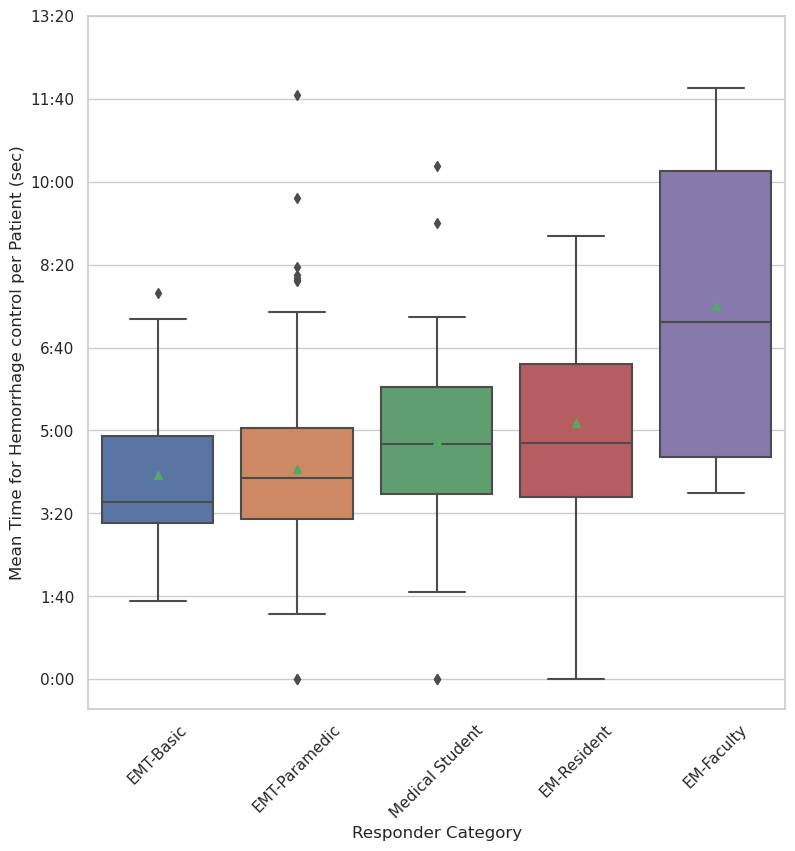

EMT-Basic: 23 responders
EMT-Paramedic: 225 responders
Medical Student: 46 responders
EM-Resident: 33 responders
EM-Faculty: 4 responders


In [101]:

y_column_name = 'time_to_hemorrhage_control'
y_label = 'Mean Time for Hemorrhage control per Patient (sec)'
scene_fn = lambda scene_df: fu.get_time_to_hemorrhage_control(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


## Triage accuracy (mean, SD, median, IQR) by each responder type (to keep things simple let's not break this out by individual tag category as we had it, but by overall rates for each responder type)

In [94]:

# Iterate through each patient of each scene of each session of the 11-patient data frame
rows_list = []
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    for (session_uuid, scene_id, patient_id), patient_df in responder_categories_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):

        # Get non-null tag applied types and patient record SALTs
        mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
        if mask_series.any():
            tags_and_salts_df = patient_df[mask_series]

            # Add the groupby columns and an account of the patient's existence to the row dictionary
            row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
            row_dict['responder_category'] = responder_category
            row_dict['patient_count'] = 1

            # Add the TAG_APPLIED tag value for this patient
            last_tag = fu.get_last_tag(tags_and_salts_df)
            row_dict['last_tag'] = last_tag

            # Add the PATIENT_RECORD SALT value for this patient
            max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
            row_dict['max_salt'] = max_salt

            # Add the predicted tag value for this patient based on the SALT value
            try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
            except Exception: predicted_tag = np.nan
            row_dict['predicted_tag'] = predicted_tag

            # Add if the tagging was correct for this patient, then the row to the list
            row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)
            rows_list.append(row_dict)

# Create the tag-to-SALT data frame
tag_to_salt_df = pd.DataFrame(rows_list)

# Convert the tagged, SALT, and predicted tag columns to their custom categorical types
tag_to_salt_df.last_tag = tag_to_salt_df.last_tag.astype(fu.colors_category_order)
tag_to_salt_df.max_salt = tag_to_salt_df.max_salt.astype(fu.salt_category_order)
tag_to_salt_df.predicted_tag = tag_to_salt_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
tag_to_salt_df = tag_to_salt_df.sort_values('predicted_tag')

In [95]:

# Get the total and correct counts for each run for each tag
rows_list = []

# Add the normal section
groupby_columns = ['session_uuid', 'scene_id', 'predicted_tag']
for responder_category, responder_categories_df in tag_to_salt_df.groupby('responder_category'):
    for (session_uuid, scene_id, predicted_tag), df in responder_categories_df.groupby(groupby_columns):
        
        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in groupby_columns}
        row_dict['responder_category'] = responder_category

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

    # Add the not-tagged section
    for (session_uuid, scene_id), df in responder_categories_df.groupby(fu.scene_groupby_columns):

        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
        row_dict['predicted_tag'] = 'Not Tagged'
        row_dict['responder_category'] = responder_category

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)
correct_count_by_tag_df.predicted_tag = correct_count_by_tag_df.predicted_tag.astype(fu.colors_category_order)


* **triage tag accuracy**

In [96]:

# Get info for triage tag accuracy
cn = 'percentage_tag_correct'
statistics_df = DataFrame([])
for responder_category, responder_categories_df in correct_count_by_tag_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        mask_series = responder_categories_df.predicted_tag.isin(fu.tag_colors[:-1])
        df = responder_categories_df[mask_series]
        df = fu.get_statistics(df, [cn])
        statistics_df = pd.concat([statistics_df, df.rename(columns={cn: responder_category}).T], axis='index')
        tta_dict = df.to_dict()[cn]
        print(
            f"{responder_category}: accurately tagged {tta_dict['mean']:.1f}% of patients (SD = {tta_dict['SD']:.1f}, Median = {tta_dict['median']},"
            f" IQR = ({tta_dict['25%']:.1f}, {tta_dict['75%']}))"
        )

# Display as HTML
statistics_df['IQR'] = '(' + statistics_df['25%'].map(lambda x: str(round(x, 1))) + ', ' + statistics_df['75%'].map(lambda x: str(x)) + ')'
for cn in ['mean', 'SD']: statistics_df[cn] = statistics_df[cn].map(lambda x: str(round(x, 1)))
columns_list = ['Mean % Accurately Tagged', 'SD', 'Median', 'IQR']
print()
HTML(statistics_df.rename(columns={'mean': columns_list[0], 'median': columns_list[2]})[columns_list].to_html())

EM Resident: accurately tagged 69.6% of patients (SD = 37.8, Median = 100.0, IQR = (50.0, 100.0))
EM-Faculty: accurately tagged 78.3% of patients (SD = 33.3, Median = 100.0, IQR = (62.5, 100.0))
EMT-Basic: accurately tagged 80.2% of patients (SD = 31.2, Median = 100.0, IQR = (70.8, 100.0))
Medical Student: accurately tagged 66.3% of patients (SD = 38.8, Median = 75.0, IQR = (33.3, 100.0))
Paramedic: accurately tagged 77.5% of patients (SD = 34.0, Median = 100.0, IQR = (66.7, 100.0))



,Mean % Accurately Tagged,SD,Median,IQR
EM Resident,69.6,37.8,100.0,"(50.0, 100.0)"
EM-Faculty,78.3,33.3,100.0,"(62.5, 100.0)"
EMT-Basic,80.2,31.2,100.0,"(70.8, 100.0)"
Medical Student,66.3,38.8,75.0,"(33.3, 100.0)"
Paramedic,77.5,34.0,100.0,"(66.7, 100.0)"


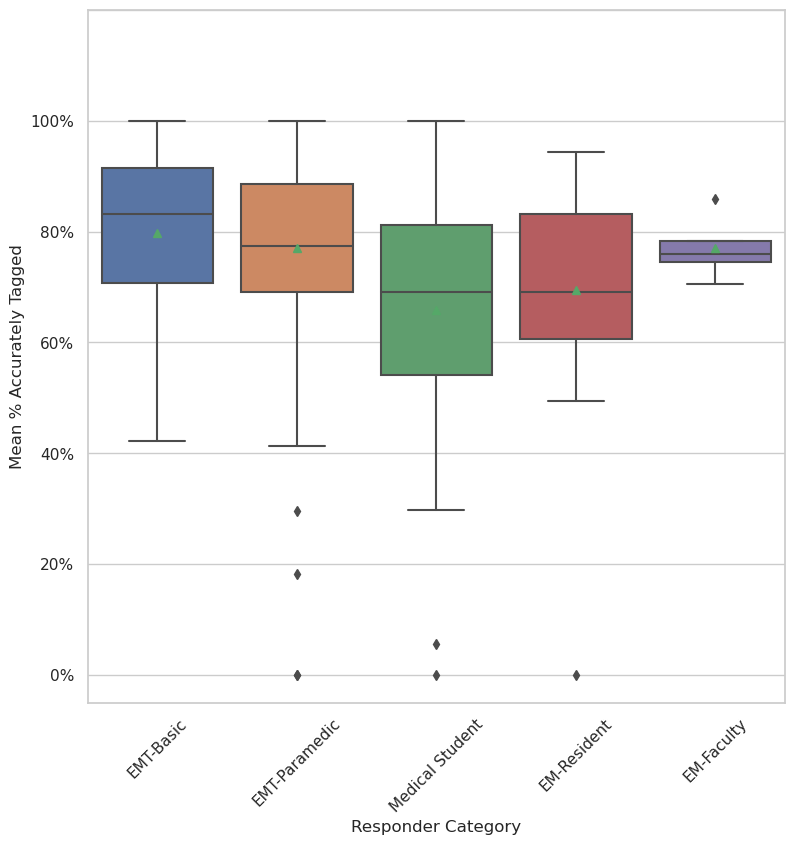

EMT-Basic: 23 responders
EMT-Paramedic: 225 responders
Medical Student: 46 responders
EM-Resident: 33 responders
EM-Faculty: 4 responders


In [108]:

y_column_name = 'percentage_tag_correct'
y_label = 'Mean % Accurately Tagged'
scene_fn = lambda scene_df: scene_df[y_column_name].mean()
percents_fn = lambda x: f'{int(x)}%' if (x<=100) else ''
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=percents_fn, logs_df=correct_count_by_tag_df)

In [109]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['last_tag', 'max_salt', 'responder_category']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])


* **over-triage error rate**


* **under-triage error rate**


* **critical-triage error rate**

In [138]:

# Get triage error rates
import re

rows_list = []
for responder_category, responder_categories_df in error_types_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        row_dict = {'responder_category': responder_category}
        df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
        total_patient_count = df.patient_count.sum()
        error_dict = df.set_index('error_type').patient_count.to_dict()

        over_patient_count = error_dict.get('Over', 0)
        over_triage_error_rate = 100*over_patient_count/total_patient_count
        row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

        under_patient_count = error_dict.get('Under', 0)
        under_triage_error_rate = 100*under_patient_count/total_patient_count
        row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

        critical_patient_count = error_dict.get('Critical', 0)
        critical_triage_error_rate = 100*critical_patient_count/total_patient_count
        row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)

        print(
            f"{responder_category}: over-triage error rate {over_triage_error_rate:.1f}%, under-triage error rate {under_triage_error_rate:.1f}%,"
            f" critical-triage error rate {critical_triage_error_rate:.1f}%"
        )
        rows_list.append(row_dict)

# Display as HTML
triage_error_rates_df = DataFrame(rows_list)
html_str = triage_error_rates_df.set_index('responder_category').to_html()
html_str = html_str.replace('<th>responder_category</th>', '<th></th>')
colspan_regex = re.compile(r'<tr style="text-align: right;">\s+<th></th>(\s+<th>[a-z]+_triage_error_rate</th>){3}\s+</tr>')
html_str = colspan_regex.sub('<tr style="text-align: right;"><th></th><th colspan="3">Triage Error Rate (%)</th></tr>', html_str, 1)
th_regex = re.compile(r"<tr>\s+<th></th>\s+<th></th>\s+<th></th>\s+<th></th>\s+</tr>")
html_str = th_regex.sub("<tr><th></th><th>Over</th><th>Under</th><th>Critical</th></tr><tr><th></th><th></th><th></th><th></th></tr>", html_str, 1)
print()
HTML(html_str)

EM Resident: over-triage error rate 10.8%, under-triage error rate 9.0%, critical-triage error rate 5.4%
EM-Faculty: over-triage error rate 9.1%, under-triage error rate 13.6%, critical-triage error rate 6.8%
EMT-Basic: over-triage error rate 9.6%, under-triage error rate 8.4%, critical-triage error rate 2.4%
Medical Student: over-triage error rate 12.1%, under-triage error rate 13.0%, critical-triage error rate 4.2%
Paramedic: over-triage error rate 10.0%, under-triage error rate 8.5%, critical-triage error rate 2.7%



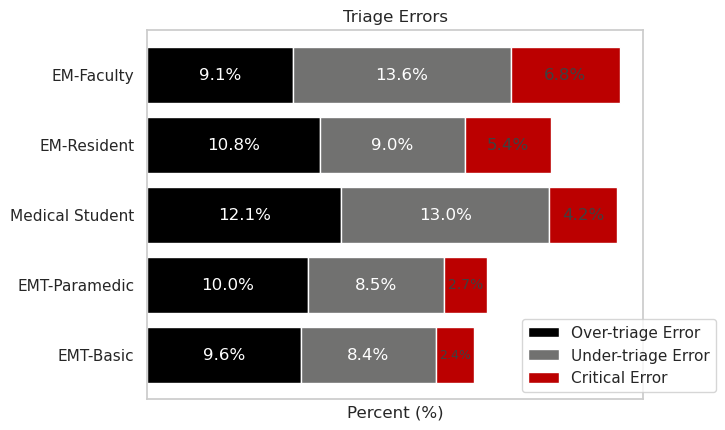

In [178]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
responder_categories_list = ['EMT-Basic', 'Paramedic', 'Medical Student', 'EM Resident', 'EM-Faculty']
responder_categories_dict = {o: n for o, n in zip(
    responder_categories_list, ['EMT-Basic', 'EMT-Paramedic', 'Medical Student', 'EM-Resident', 'EM-Faculty']
)}
over_values, under_values, critical_values = [], [], []
for responder_category in responder_categories_list:
    mask_series = (triage_error_rates_df.responder_category == responder_category)
    df = triage_error_rates_df[mask_series]
    over_values.append(df.over_triage_error_rate.squeeze())
    under_values.append(df.under_triage_error_rate.squeeze())
    critical_values.append(df.critical_triage_error_rate.squeeze())

# Create a horizontal bar chart for the first set of values
over_bar = plt.barh([responder_categories_dict[o] for o in responder_categories_list], over_values, color='#000000', label=suffixing_fn('Over'))

# Create a stacked horizontal bar chart for the second set of values
under_bar = plt.barh(
    [responder_categories_dict[o] for o in responder_categories_list], under_values, color='#717170', label=suffixing_fn('Under'), left=over_values
)

# Create a stacked horizontal bar chart for the third set of values
critical_bar = plt.barh([
    responder_categories_dict[o] for o in responder_categories_list], critical_values, color='#bb0000', label=suffixing_fn('Critical'),
    left=[v1 + v2 for v1, v2 in zip(over_values, under_values)
])

# Annotate the values of each value set inside their respective rectangles
facecolor_set = set()
for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
    for bar, value in zip(bars, values):
        facecolor_set.add(str(bar.get_facecolor()))
        if (bar.get_facecolor() == (0.7333333333333333, 0.0, 0.0, 1.0)):
            if (value > 2.7): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='#404040'
            )
            elif (value > 2.4): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='#404040',
                fontdict={'size': 10}
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='#404040',
                fontdict={'size': 9}
            )
        else:
            if (value > 2.4): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width() + 1.2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='black'
            )

# Set the title, labels, and grid
plt.title('Triage Errors')
plt.xlabel('Percent (%)')
plt.ylabel('')
plt.grid(False)

# Set legend placement outside the plot
plt.legend(loc='lower left', bbox_to_anchor=(0.74, 0))

# Remove x-axis ticks
plt.xticks([])

# Display the chart
plt.show()


## SALT triage performance


Once Nick provides this, check against "3 correct orders" by marking anything outside of these orders as incorrect. We can also check performance for each of the different categories (walker, waver, still, life-threatening)


# Maintenance/Attic

In [8]:

# Got it. So some people treated the same injury twice which you excluded which makes sense. And what were the errors that people made?
columns_list = [
    'injury_id', 'injury_required_procedure'
]
mask_series = (elevens_df.injury_treated_injury_treated_with_wrong_treatment == True)
elevens_df[mask_series][columns_list].drop_duplicates(subset=columns_list, keep='last').sort_values(columns_list)

,injury_id,injury_required_procedure
188374,Face Shrapnel,gauzePressure
400747,Face Shrapnel,airway
10347,Forehead Scrape,gauzePressure
300718,Forehead Scrape,none
401011,L Forearm Laceration,gauzePressure
374878,L Side Puncture,woundpack
394051,L Thigh Puncture,tourniquet
221235,R Bicep Puncture,tourniquet
392566,R Calf Laceration,gauzePressure
189625,R Calf Shrapnel,tourniquet


In [25]:

# Provide OSU with 10 example CSVs that demonstrate the low hemorrhage percents
rows_list = []
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    row_dict['wrong_treatment_count'] = scene_df[scene_df.injury_treated_injury_treated_with_wrong_treatment == True].shape[0]
    row_dict['hemorrhage_count'] = scene_df[scene_df.injury_treated_required_procedure.isin(fu.hemorrhage_control_procedures_list)].shape[0]
    rows_list.append(row_dict)
df = DataFrame(rows_list)
session_uuids_list = sorted(df.sort_values(['hemorrhage_count', 'wrong_treatment_count'], ascending=[False, False]).head(10).session_uuid)
mask_series = file_stats_df.session_uuid.isin(session_uuids_list)
list_str = nu.conjunctify_nouns(sorted(file_stats_df[mask_series].session_file_name))
print(f'I think {list_str} provide excellent examples of tools applied wrongly multiple times to treat hemorrhages.')

I think 22.03.16.0944.csv, 22.03.16.1215r.csv, 22.03.16.1239.csv, 22.12.06.1332.csv, 22.12.07.0804.csv, 22.12.07.1305.csv, 22.12.08.0835.csv, 22.12.08.1316.csv, 23.03.14.0807.csv, and 23.08.02.0802.csv provide excellent examples of tools applied wrongly multiple times to treat hemorrhages.
